In [25]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import plotly.io as pio

from ocean_navigation_simulator.controllers.hj_planners.Platform2dForSim import (
    Platform2dForSim
)
pio.renderers.default = "browser"
import time

import hj_reachability as hj
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import xarray as xr
from scipy.interpolate import interp1d
from functools import partial
from ocean_navigation_simulator.controllers.hj_planners.Platform2dForSim import Platform2dForSim
# from jax.config import config
# config.update('jax_disable_jit', True)


In [26]:
class Platform2dObsForSimToy(Platform2dForSim):
    def __init__(
        self,
        u_max: float,
        d_max: float = 0,
        use_geographic_coordinate_system: bool = True,
        control_mode:str = "min",
        disturbance_mode:str  = "max",
        obstacle_ds=None,
    ):
        super().__init__(
            u_max, d_max, use_geographic_coordinate_system, control_mode, disturbance_mode
        )
        self.obstacle_ds = obstacle_ds["obstacles"]

    def update_jax_interpolant(self, data_xarray: xr):
        """Creating an interpolant function from x,y,t grid and data
        Args:
            data_xarray: xarray containing variables water_u and water_v as matrices (T, Y, X)
        """
        super().update_jax_interpolant(data_xarray)
        self.obstacle_array = self.create_obstacle_array(data_xarray)

    def __call__(self, state, control, disturbance, time):
        """Implements the continuous-time dynamics ODE with obstacles."""
        dx_out = super().__call__(state, control, disturbance, time)
        # Check if state is in obstacle then mask dx_out,
        # this means that the "state moves with obstacle" and can not leave it.
        # Additionally, we mask the obstacles in the hamiltonian_postprocessor in "HJPLannerBase"
        # to counter the dissipation value of the artificial_dissipation_scheme
        # TODO: Would actually need to change the 0 to velocity of obstacle if obstacle were dynamic
        return jnp.zeros_like(dx_out) if self.is_in_obstacle(state, time) else dx_out
        # out = jnp.where(self.is_in_obstacle(state, time), 0, dx_out)
        # if out.shape != dx_out.shape:
        #     return 

    def create_obstacle_array(self, data_xarray):
        """Use path to file to load and set the obstacle array"""
        # Fit to grid
        obstacle_array = self.obstacle_ds.interp_like(data_xarray)
        # Convert to binary mask, set to 0 for "no obstacle" and 1 for "obstacle"
        return jnp.array(obstacle_array.data)

    def is_in_obstacle(self, state, time):
        """Return if the state is in the obstacle region"""
        x_idx = jnp.argmin(jnp.abs(self.obstacle_array - state[0]))
        y_idx = jnp.argmin(jnp.abs(self.obstacle_array - state[1]))
        # The 0 index is time and 0 because we do not have dynamics
        return self.obstacle_array[y_idx, x_idx, 0] > 0


In [27]:
from hj_reachability import systems

class Platform2DcurrentsObs(systems.Platform2Dcurrents):
    def __init__(self,
                 u_max=1.,
                 d_max=0,
                 control_mode="min",
                 disturbance_mode="max",
                 control_space=None,
                 disturbance_space=None,
                 x_current=None,
                 y_current=None,
                 obs_loc=None,
                 obs_vel=None):

        self.obs_loc = obs_loc
        self.obs_vel = obs_vel
        super().__init__(u_max, d_max, control_mode, disturbance_mode,
                control_space, disturbance_space, x_current, y_current)

    def __call__(self, state, control, disturbance, time):
        return jnp.where(self.obs_loc(jnp.append(state, time)) < 0,
                self.obs_vel(jnp.append(state, time)),
                super().__call__(state, control, disturbance, time))

In [28]:
times = np.linspace(0, 100, 100)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    hj.sets.Box(lo=np.array([-5.0, -5.0]), hi=np.array([5.0, 5.0])), (100, 100)
)
x_init = [-4, -4]
x_target = [4, 4]
r = 0.1
initial_values = hj.shapes.shape_sphere(grid=grid, center=x_target, radius=r)
initial_values[initial_values<0]=0

In [29]:
def multi_reach_step(mask, val):
    #val = jnp.where(mask<0,-1,val)
    alpha = 1
    val = jnp.where(mask <0, val-alpha, val)
    return val

p_multi_reach_step = partial(multi_reach_step, initial_values)

solver_settings = hj.SolverSettings.with_accuracy("high",
                    x_init = [np.nan, np.nan],#x_init,
                    artificial_dissipation_scheme =
                        hj.artificial_dissipation.local_local_lax_friedrichs,
                    hamiltonian_postprocessor = p_multi_reach_step,
                    CFL_number=1.0
                    )

In [30]:
def checkerboard(shape):
    return np.indices(shape).sum(axis=0) % 2

In [31]:
# T,  y, x
water_u = np.zeros((100, 100, 100))
water_v = np.zeros((100, 100, 100))
obs = np.zeros((100, 100, 100))

# Create checkerboard shaped obstacles
obs[:, 40:60, 40:60] = checkerboard([20, 20])


lon = np.linspace(-5, 5, 100)
lat = np.linspace(-5, 5, 100)
time = np.linspace(0, -60, 100)


In [32]:
ds_obs = xr.Dataset(
    data_vars=dict(
        obstacles=(["relative_time", "lat", "lon"], obs),
    ),
    coords=dict(
        lon=lon,
        lat=lat,
        relative_time=time,
    ),
)

ds_water = xr.Dataset(
    data_vars=dict(
        water_u=(["relative_time", "lat", "lon"], water_u),
        water_v=(["relative_time", "lat", "lon"], water_v),
    ),
    coords=dict(
        lon=lon,
        lat=lat,
        relative_time=time,
    ),
)

In [33]:
Plat2D = Platform2dObsForSimToy(#Platform2dForSim
    u_max=0.2,
    d_max=0,
    use_geographic_coordinate_system=False,
    control_mode="min",
    disturbance_mode="max",
    obstacle_ds=ds_obs
)

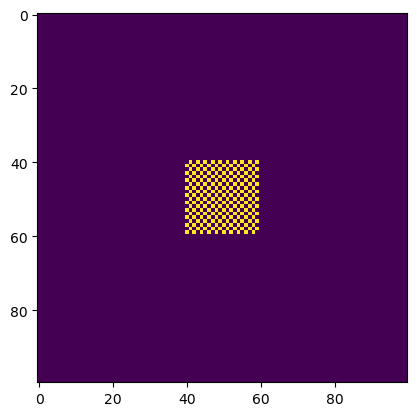

In [34]:
plt.imshow(ds_obs["obstacles"].data[0, ...])


In [35]:
Plat2D.update_jax_interpolant(ds_water)


In [37]:
times, all_values = hj.solve(solver_settings, Plat2D, grid, times, initial_values, progress_bar=True)


  0%|          |  0.0000/100.0 [00:04<?, ?sim_s/s]


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(int32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(int32[100])>with<BatchTrace(level=1/0)> with
    val = DeviceArray([[ 0,  0,  0, ...,  0,  0,  0],
             [ 1,  1,  1, ...,  1,  1,  1],
             [ 2,  2,  2, ...,  2,  2,  2],
             ...,
             [97, 97, 97, ..., 97, 97, 97],
             [98, 98, 98, ..., 98, 98, 98],
             [99, 99, 99, ..., 99, 99, 99]], dtype=int32)
    batch_dim = 0
  batch_dim = 0
This Tracer was created on line /home/andy/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/hj_reachability/interpolation.py:38 (lin_interpo_1D)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [ ]:
hj.viz.visSet2DAnimation(grid, all_values, times, type='html', x_init=x_init,
        colorbar=True, filename='generated_media/multireach', interval=30)

In [ ]:
hj.viz.visValFuncTraj(
    ax,
    traj_times=traj_times,
    x_traj=self.planned_trajs[-1]["traj"][:2, :],
    all_times=reach_times,
    all_values=all_values,
    grid=grid,
    flip_times=False,
    ylabel=ylabel,
)